# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Project Overview
Create a supervised machine learning model to predict the user's churn based on the user's previous interaction with the Sparkify music application. The project was created as part of the Udacity Data Scientist Nanodegree program. The data set was obtained as part of the Udacity Data Scientist Nanodegree program.

### Data
 - artist (string) - Artist Name
 - auth (string) - Authorization (Cancelled, Guest, Logged In, Logged Out)
 - firstName (string) - User's first name
 - gender (string) - User's gender (null, F, M)
 - itemInSession (long) - Item in Session
 - lastName (string) - User's last name
 - length (double) - Length of a session
 - level (string) - User's account level (free, paid)
 - location (string) - User's location
 - method (string) - User's method (GET, PUT)
 - page (string) - Page on which the user was (About, Add Friend, Add to Playlist, Cancel, Cancellation Confirmation, Downgrade, Error, Help, Home, Logout, NextSong, Roll Advert, Save Settings, Settings, Submit Downgrade, Submit Upgrade, Thumbs Down, Thumbs Up, Upgrade)
 - registration (long) - registration id
 - sessionId (long) - sessionId
 - song (string) - name of the song being played
 - status (long) - HTTP Status
 - ts (long) - timestamp
 - userAgent (string) - User's browser/platform information
 - userId (string) - user's Id
 
 
 ### Approach
 A supervised machine learning model will be trained based on the various data columns within the Sparkify data set, the models will be compared based on F1 measure.

In [96]:
# import libraries
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType
from pyspark import SparkConf
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Normalizer, StandardScaler, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

import datetime

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [41]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Data Analysis") \
    .getOrCreate()

In [42]:
# Update the limists on the number of columns and rows to display
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 1000)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [43]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1596041664235'),
 ('spark.driver.port', '45733'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify Data Analysis'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '3ab3375d4621'),
 ('spark.ui.showConsoleProgress', 'true')]

In [44]:
spark

In [45]:
event_data = spark.read.json("mini_sparkify_event_data.json", encoding = "utf-8")

In [46]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [47]:
event_data.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [48]:
event_data.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [49]:
event_data.count()

286500

In [50]:
def viewUnique (fieldId, event_data = event_data):
    '''
    Display a sorted list of unique values for a spark dataframe and column combination
    
    Keyword arguments:
    fieldId - column name
    event_data - spark dataframe
    
    '''
    return event_data.select(fieldId).dropDuplicates().sort(fieldId).show()

In [51]:
viewUnique ("userId")

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [52]:
viewUnique ("sessionId")

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [53]:
viewUnique ("auth")

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [54]:
viewUnique ("gender")

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



In [55]:
viewUnique ("level")

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [56]:
viewUnique ("method")

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



In [57]:
# remove rows with na valid for userId or sessionId or an invalid userId
event_data = event_data.dropna(how = "any", subset = ["userId", "sessionId"])
event_data = event_data.filter(event_data["userId"] != "")

In [58]:
event_data.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [59]:
df = event_data.toPandas()

In [60]:
df.query("userId=='30'")

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
12,Edward Sharpe & The Magnetic Zeros,Logged In,Colin,M,56,Freeman,223.58159,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Jade,200,1538353218000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
15,Stan Mosley,Logged In,Colin,M,57,Freeman,246.69995,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,So-Called Friends,200,1538353441000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
18,Orishas,Logged In,Colin,M,58,Freeman,222.22322,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Represent,200,1538353687000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
21,Downhere,Logged In,Colin,M,59,Freeman,223.92118,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Here I Am,200,1538353909000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [61]:
df.level.unique()

array(['paid', 'free'], dtype=object)

In [62]:
df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [63]:
# View the list of all the visited pages
event_data.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [64]:
flag_event = udf(lambda x: "Cancellation" if x == "Cancellation Confirmation" else ("Downgrade" if x == "Submit Downgrade" else ("Upgrade" if x == "Submit Upgrade" else "Other")), StringType())
event_data = event_data.withColumn("AccountEvent", flag_event("page"))

In [65]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
event_data = event_data.withColumn("Churn", flag_churn_event("page"))
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
event_data = event_data.withColumn("Downgrade", flag_downgrade_event("page"))
flag_upgrade_event = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
event_data = event_data.withColumn("Upgrade", flag_upgrade_event("page"))

In [66]:
df = event_data.toPandas()
df.query("Churn!=0").head(100)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,AccountEvent,Churn,Downgrade,Upgrade
19592,None,Cancelled,Adriel,M,104,Mendoza,NaN,paid,"Kansas City, MO-KS",GET,Cancellation Confirmation,1535623466000,514,None,200,1538943990000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18,Cancellation,1,0,0
23072,None,Cancelled,Diego,M,56,Mckee,NaN,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Cancellation Confirmation,1537167593000,540,None,200,1539033046000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32,Cancellation,1,0,0
36649,None,Cancelled,Mason,M,10,Hart,NaN,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,Cancellation,1,0,0
39109,None,Cancelled,Alexander,M,332,Garcia,NaN,paid,"Indianapolis-Carmel-Anderson, IN",GET,Cancellation Confirmation,1536817381000,508,None,200,1539375441000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105,Cancellation,1,0,0
40728,None,Cancelled,Kayla,F,273,Johnson,NaN,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",GET,Cancellation Confirmation,1538333829000,797,None,200,1539465584000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,17,Cancellation,1,0,0
43251,None,Cancelled,Molly,F,29,Harrison,NaN,free,"Virginia Beach-Norfolk-Newport News, VA-NC",GET,Cancellation Confirmation,1534255113000,843,None,200,1539588854000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",143,Cancellation,1,0,0
51134,None,Cancelled,Alex,M,145,Hogan,NaN,paid,"Denver-Aurora-Lakewood, CO",GET,Cancellation Confirmation,1535066380000,842,None,200,1539729037000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101,Cancellation,1,0,0
51579,None,Cancelled,Davis,M,34,Wang,NaN,paid,"Flint, MI",GET,Cancellation Confirmation,1538289776000,802,None,200,1539736161000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",129,Cancellation,1,0,0
52831,None,Cancelled,Nikolas,M,287,Olsen,NaN,paid,"Oxnard-Thousand Oaks-Ventura, CA",GET,Cancellation Confirmation,1528403713000,881,None,200,1539759749000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,121,Cancellation,1,0,0
52967,None,Cancelled,Ethan,M,176,Johnson,NaN,paid,"Lexington-Fayette, KY",GET,Cancellation Confirmation,1538080987000,934,None,200,1539761972000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",51,Cancellation,1,0,0


In [67]:
df.query("Downgrade!=0").head(100)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,AccountEvent,Churn,Downgrade,Upgrade
878,None,Logged In,Kael,M,47,Baker,NaN,paid,"Kingsport-Bristol-Bristol, TN-VA",PUT,Submit Downgrade,1533102330000,249,None,307,1538393619000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,Downgrade,0,1,0
5324,None,Logged In,Calvin,M,17,Marshall,NaN,paid,"Pittsburgh, PA",PUT,Submit Downgrade,1537120757000,313,None,307,1538516445000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",38,Downgrade,0,1,0
16110,None,Logged In,Kaylenn,F,354,Jenkins,NaN,paid,"Price, UT",PUT,Submit Downgrade,1535903878000,479,None,307,1538835479000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",141,Downgrade,0,1,0
21218,None,Logged In,Colin,M,214,Freeman,NaN,paid,"Bakersfield, CA",PUT,Submit Downgrade,1538173362000,532,None,307,1538995454000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Downgrade,0,1,0
21276,None,Logged In,Destiny,F,2,Herring,NaN,paid,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,Submit Downgrade,1536844410000,378,None,307,1538997356000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",20,Downgrade,0,1,0
28147,None,Logged In,Sophia,F,42,Perry,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,Submit Downgrade,1533885783000,632,None,307,1539144047000,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,12,Downgrade,0,1,0
33484,None,Logged In,Zoe,F,23,Patel,NaN,paid,"Providence-Warwick, RI-MA",PUT,Submit Downgrade,1532554781000,487,None,307,1539239742000,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,11,Downgrade,0,1,0
33695,None,Logged In,Parker,M,636,Williams,NaN,paid,"San Francisco-Oakland-Hayward, CA",PUT,Submit Downgrade,1537188538000,529,None,307,1539244188000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like...",61,Downgrade,0,1,0
34646,None,Logged In,Oliver,M,89,Gilbert,NaN,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PUT,Submit Downgrade,1535093367000,725,None,307,1539264337000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",81,Downgrade,0,1,0
37227,None,Logged In,Brayden,M,113,Thomas,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,Submit Downgrade,1534133898000,734,None,307,1539335599000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",85,Downgrade,0,1,0


In [68]:
df.query("Upgrade!=0").head(100)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,AccountEvent,Churn,Downgrade,Upgrade
351,None,Logged In,Grant,M,11,Flores,NaN,free,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Submit Upgrade,1538120859000,141,None,307,1538373719000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",142,Upgrade,0,0,1
734,None,Logged In,Kael,M,26,Baker,NaN,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,Submit Upgrade,1533102330000,249,None,307,1538389931000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,Upgrade,0,0,1
3939,None,Logged In,Sadie,F,35,Jones,NaN,free,"Denver-Aurora-Lakewood, CO",PUT,Submit Upgrade,1537054553000,131,None,307,1538477767000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",132,Upgrade,0,0,1
4724,None,Logged In,Alex,M,18,Hogan,NaN,free,"Denver-Aurora-Lakewood, CO",PUT,Submit Upgrade,1535066380000,312,None,307,1538502571000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101,Upgrade,0,0,1
5429,None,Logged In,Alexander,M,39,Garcia,NaN,free,"Indianapolis-Carmel-Anderson, IN",PUT,Submit Upgrade,1536817381000,104,None,307,1538518220000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105,Upgrade,0,0,1
6491,None,Logged In,Rachel,F,17,Bailey,NaN,free,"Albany-Schenectady-Troy, NY",PUT,Submit Upgrade,1536102943000,72,None,307,1538545275000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,73,Upgrade,0,0,1
7009,None,Logged In,Chayse,M,6,Keller,NaN,free,"Jackson, MS",PUT,Submit Upgrade,1529643103000,376,None,307,1538565618000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",70,Upgrade,0,0,1
7962,None,Logged In,Madelyn,F,44,Henson,NaN,free,"Charlotte-Concord-Gastonia, NC-SC",PUT,Submit Upgrade,1532920994000,366,None,307,1538589766000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",113,Upgrade,0,0,1
9082,None,Logged In,Erick,M,49,Brooks,NaN,free,"Selma, AL",PUT,Submit Upgrade,1537956751000,325,None,307,1538625872000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",58,Upgrade,0,0,1
9697,None,Logged In,Emma,F,165,Lee,NaN,free,"Winston-Salem, NC",PUT,Submit Upgrade,1536597540000,185,None,307,1538645368000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",16,Upgrade,0,0,1


In [69]:
df.query("AccountEvent!='0'").head(100)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,AccountEvent,Churn,Downgrade,Upgrade
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,Other,0,0,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,Other,0,0,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,Other,0,0,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,Other,0,0,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0


In [70]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
event_data = event_data.withColumn("hour", get_hour(event_data.ts))
songs_in_hour = event_data.filter(event_data.page == "NextSong").groupby(event_data.hour).count().orderBy(event_data.hour.cast("float"))

In [71]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [72]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

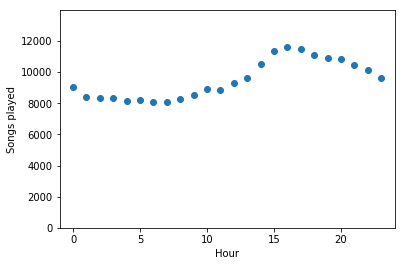

In [76]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [77]:
event_data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', AccountEvent='Other', Churn=0, Downgrade=0, Upgrade=0, hour='0')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 22 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null int64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
AccountEvent     278154 non-null object
Churn            278154 non-null int32
Downgrade        278154 non-null int32
Upgrade          278154 non-null int32
dtypes: float64(

In [79]:
df.groupby ("artist").count()

,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,AccountEvent,Churn,Downgrade,Upgrade
artist,,,,,,,,,,,,,,,,,,,,,
!!!,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
& And Oceans,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
'N Sync/Phil Collins,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
'Til Tuesday,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
't Hof Van Commerce,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
't Hof Van Commerce & Brahim,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
(Love) Tattoo,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
(hed) p.e.,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
*NSYNC featuring Nelly,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [80]:
df.groupby ("location").count()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,method,page,registration,sessionId,song,status,ts,userAgent,userId,AccountEvent,Churn,Downgrade,Upgrade
location,,,,,,,,,,,,,,,,,,,,,
"Albany, OR",11,23,23,23,23,23,11,23,23,23,23,23,11,23,23,23,23,23,23,23,23
"Albany-Schenectady-Troy, NY",377,457,457,457,457,457,377,457,457,457,457,457,377,457,457,457,457,457,457,457,457
"Alexandria, LA",734,955,955,955,955,955,734,955,955,955,955,955,734,955,955,955,955,955,955,955,955
"Allentown-Bethlehem-Easton, PA-NJ",640,815,815,815,815,815,640,815,815,815,815,815,640,815,815,815,815,815,815,815,815
"Anchorage, AK",1235,1496,1496,1496,1496,1496,1235,1496,1496,1496,1496,1496,1235,1496,1496,1496,1496,1496,1496,1496,1496
"Atlanta-Sandy Springs-Roswell, GA",3479,4236,4236,4236,4236,4236,3479,4236,4236,4236,4236,4236,3479,4236,4236,4236,4236,4236,4236,4236,4236
"Atlantic City-Hammonton, NJ",1802,2176,2176,2176,2176,2176,1802,2176,2176,2176,2176,2176,1802,2176,2176,2176,2176,2176,2176,2176,2176
"Austin-Round Rock, TX",1412,1682,1682,1682,1682,1682,1412,1682,1682,1682,1682,1682,1412,1682,1682,1682,1682,1682,1682,1682,1682
"Bakersfield, CA",1417,1775,1775,1775,1775,1775,1417,1775,1775,1775,1775,1775,1417,1775,1775,1775,1775,1775,1775,1775,1775


In [81]:
df.groupby ("userId", ).count()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,AccountEvent,Churn,Downgrade,Upgrade
userId,,,,,,,,,,,,,,,,,,,,,
10,673,795,795,795,795,795,673,795,795,795,795,795,795,673,795,795,795,795,795,795,795
100,2682,3214,3214,3214,3214,3214,2682,3214,3214,3214,3214,3214,3214,2682,3214,3214,3214,3214,3214,3214,3214
100001,133,187,187,187,187,187,133,187,187,187,187,187,187,133,187,187,187,187,187,187,187
100002,195,218,218,218,218,218,195,218,218,218,218,218,218,195,218,218,218,218,218,218,218
100003,51,78,78,78,78,78,51,78,78,78,78,78,78,51,78,78,78,78,78,78,78
100004,942,1245,1245,1245,1245,1245,942,1245,1245,1245,1245,1245,1245,942,1245,1245,1245,1245,1245,1245,1245
100005,154,216,216,216,216,216,154,216,216,216,216,216,216,154,216,216,216,216,216,216,216
100006,26,44,44,44,44,44,26,44,44,44,44,44,44,26,44,44,44,44,44,44,44
100007,423,520,520,520,520,520,423,520,520,520,520,520,520,423,520,520,520,520,520,520,520


In [82]:
df.groupby (["AccountEvent", "userId"]).count().head(100)

artist  auth  firstName  gender  itemInSession  lastName  \
AccountEvent userId                                                             
Cancellation 100001       0     1          1       1              1         1   
             100003       0     1          1       1              1         1   
             100005       0     1          1       1              1         1   
             100006       0     1          1       1              1         1   
             100007       0     1          1       1              1         1   
             100009       0     1          1       1              1         1   
             100011       0     1          1       1              1         1   
             100012       0     1          1       1              1         1   
             100013       0     1          1       1              1         1   
             100014       0     1          1       1              1         1   
             100015       0     1          1       1              1         1   
             100017       0     1          1       1              1         1   
             100019       0     1          1       1              1         1   
             100021       0     1          1       1              1         1   
             100022       0     1          1       1              1         1   
             100023       0     1          1       1              1         1   
             100024       0     1          1       1              1         1   
             100025       0     1          1       1              1         1   
             101          0     1          1       1              1         1   
             103          0     1          1       1              1         1   
             105          0     1          1       1              1         1   
             106          0     1          1       1              1         1   
             12           0     1          1       1              1         1   
             121          0     1          1       1              1         1   
             122          0     1          1       1              1         1   
             125          0     1          1       1              1         1   
             129          0     1          1       1              1         1   
             143          0     1          1       1              1         1   
             17           0     1          1       1              1         1   
             18           0     1          1       1              1         1   
             200001       0     1          1       1              1         1   
             200011       0     1          1       1              1         1   
             200015       0     1          1       1              1         1   
             200016       0     1          1       1              1         1   
             200017       0     1          1       1              1         1   
             200018       0     1          1       1              1         1   
             200020       0     1          1       1              1         1   
             200021       0     1          1       1              1         1   
             200024       0     1          1       1              1         1   
             28           0     1          1       1              1         1   
             29           0     1          1       1              1         1   
             3            0     1          1       1              1         1   
             300001       0     1          1       1              1         1   
             300007       0     1          1       1              1         1   
             32           0     1          1       1              1         1   
             51           0     1          1       1              1         1   
             53           0     1          1       1              1         1   
             54           0     1          1       1

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [83]:
# Get the number of songs by user
function = event_data.filter(event_data.page == "NextSong").groupby("userId").count().filter (event_data.userId=="100010").collect()
songs_by_user = udf(lambda x: function [0][1] if len(function)>0 else 0, IntegerType())
event_data = event_data.withColumn("songs_by_user", songs_by_user("userId"))

In [85]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- AccountEvent: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Upgrade: integer (nullable = true)
 |-- hour: string (nullable = true)
 |-- songs_by_user: integer (nullable = true)



In [86]:
event_data.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, AccountEvent: string, Churn: string, Downgrade: string, Upgrade: string, hour: string, songs_by_user: string]

In [87]:
event_data.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', AccountEvent='Other', Churn=0, Downgrade=0, Upgrade=0, hour='0', songs_by_user=275),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', AccountEvent='Other', Churn=0, Downgrade=0, Upgrade=0, hour='0', songs_by

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Step 1. Train Test Split
As a first step we'll break the data set into train/test/validation:
 - 80% for training the model
 - 10% for testing the model
 - 10% for validating the model

In [88]:
train, rest = event_data.randomSplit([0.8, 0.2])

In [89]:
test, validation = rest.randomSplit([0.5, 0.5])

In [90]:
train.count()

222243

In [91]:
test.count()

28087

In [92]:
validation.count()

27824

In [93]:
event_data.count()

278154

### Step 2. Build Pipeline

In [94]:
level_indexer = StringIndexer(inputCol="level", outputCol="encoded_level")
gender = StringIndexer(inputCol="gender", outputCol="encoded_gender")
page_indexer = StringIndexer (inputCol = "page", outputCol ="page_ind")
page_one_hot_encoding = OneHotEncoder (inputCol = "page_ind", outputCol ="encoded_page")
#normalizer_songs_by_user = Normalizer(inputCol="songs_by_user", outputCol="ScaledSongsByUser")
#scaler_songs_by_user = StandardScaler(inputCol="ScaledSongsByUser", outputCol="ScaledSongsByUser2", withStd=True)

assembler = VectorAssembler(inputCols=["encoded_level", "encoded_page", "encoded_gender", "songs_by_user"], outputCol="features")
indexer = StringIndexer(inputCol="Churn", outputCol="label")

lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[level_indexer, gender, page_indexer, page_one_hot_encoding, assembler, indexer, lr])

### Step 3. Tune Model
Train the logistic regression model on the train set using 3-fold cross-validation with the following parameter grid:

- LogisticRegression regularization parameter: `[0.0, 0.1, 0.2, 0.3]`
- LogisticRegression elasticNet parameter: `[0.0, 0.2, 0.4, 0.6, 0.8]`
- LogisticRegression max Iteration number: `[10, 20]`

Set the evaluation metric to f1 score.

In [97]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, 0.2, 0.3]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.2, 0.4, 0.6, 0.8]) \
    .addGrid(lr.maxIter,[10, 20]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds=3)

In [98]:
cvModel_q1 = crossval.fit(train)

In [99]:
cvModel_q1.avgMetrics

[0.999959613244694,
 1.0,
 0.999959613244694,
 1.0,
 0.999959613244694,
 1.0,
 0.999959613244694,
 1.0,
 0.999959613244694,
 1.0,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478,
 0.9996963273768478]

In [100]:
results = cvModel_q1.transform(test)

### Step 4: Compute Accuracy of Best Model

In [101]:
correct_predictions = results.filter(results.label == results.prediction).count()
number_of_predictions = results.count()

In [102]:
accuracy = correct_predictions / number_of_predictions
accuracy

1.0

In [103]:
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,AccountEvent,Churn,Downgrade,Upgrade
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,Other,0,0,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,Other,0,0,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Other,0,0,0


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.